In [2]:
import os
import numpy as np

from sunpy.net import Fido, attrs as a
import astropy.units as u

import sunpy.map
from astropy.io import fits

from aiapy.calibrate import correct_degradation
from aiapy.calibrate.util import get_correction_table
import aiapy.psf

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import cv2
from PIL import Image

import shutil

import time
import datetime
from dateutil.relativedelta import relativedelta

from concurrent.futures import ThreadPoolExecutor

In [3]:
download_dir = 'D:/aia_synoptic_data'

# List all files in the download directory
aia_files = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith('.fits')]

In [12]:
new_aia_files = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith('.fits')]

In [18]:
# Find elements that are unique to each list
unique_new_files = list(set(new_aia_files) - set(aia_files))


print(f"Original aia_files count: {len(aia_files)}")
print(f"Original new_aia_files count: {len(new_aia_files)}")
print(f"Files unique to new_aia_files: {len(unique_new_files)}")

Original aia_files count: 121975
Original new_aia_files count: 123688
Files unique to new_aia_files: 1713


In [3]:

def fix_aia_files(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        # Disable memory mapping and use a context manager
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            hdul.verify('fix')
            # hdul[1].header.remove('TEMPSMIR', ignore_missing=True)
            # hdul[1].header.remove('TEMPFPAD', ignore_missing=True)
            # hdul[1].header.remove('TEMPCCD', ignore_missing=True)
            # hdul[1].header.remove('OSCNRMS', ignore_missing=True)
            # hdul[1].header.remove('OSCNMEAN', ignore_missing=True)
            # hdul[1].header.remove('TEMPGT', ignore_missing=True)
            # No need to close when using context manager
    except TypeError as e:
        if "buffer is too small" in str(e):
            print(f"Buffer error in file {aia_file_path}: {e}")
            return f"BUFFER ERROR: {aia_file_path}"
        return f"TYPE ERROR: {aia_file_path}, Error: {e}"
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(fix_aia_files, aia_files), total=len(aia_files), desc="Fixing AIA Files"))


Fixing AIA Files:   0%|          | 0/121972 [00:00<?, ?it/s]

In [16]:
bad_quality_files = []
def check_file_quality(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            # Check if the quality is bad add to the list
            if header['QUALITY'] != 0:
                bad_quality_files.append(aia_file_path)
                # print(f"Bad quality file: {file}")
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(check_file_quality, unique_new_files), total=len(unique_new_files), desc="Checking file quality"))

print(len(bad_quality_files))

bad_quality_files_file = os.path.join(download_dir, 'bad_quality_files.txt')
with open(bad_quality_files_file, 'w') as f:
    for file in bad_quality_files:
        f.write(f"{file}\n")
        
        
# delete all bad quality files
for bad_file in bad_quality_files:
    os.remove(bad_file)
    



Checking file quality:   0%|          | 0/7498 [00:00<?, ?it/s]

1673


#### Correct for Camera degradation

In [19]:
correction_table = get_correction_table("JSOC")
print("Got correction table")

def correct_degradation_file(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            aia_map = sunpy.map.Map((data, header))
            aia_map_corrected = correct_degradation(aia_map, correction_table=correction_table)
            hdul[1].data = aia_map_corrected.data
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(correct_degradation_file, aia_files), total=len(aia_files), desc="Degradation Correction"))

Got correction table


Degradation Correction:   0%|          | 0/121975 [00:00<?, ?it/s]

2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1007616) is smaller than the expected size (1206720)
2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1007616) is smaller than the expected size (1203840)
2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1155072) is smaller than the expected size (1203840)


#### Normalize the images by dividing by their exposure time

In [20]:
def normalize_by_exposure(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            aia_map = sunpy.map.Map((data, header))
            aia_map_normalized = aia_map / aia_map.exposure_time
            hdul[1].data = aia_map_normalized.data
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(normalize_by_exposure, aia_files), total=len(aia_files), desc="Normalizing by Exposure Time"))


Normalizing by Exposure Time:   0%|          | 0/121975 [00:00<?, ?it/s]

Calculating pixel distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

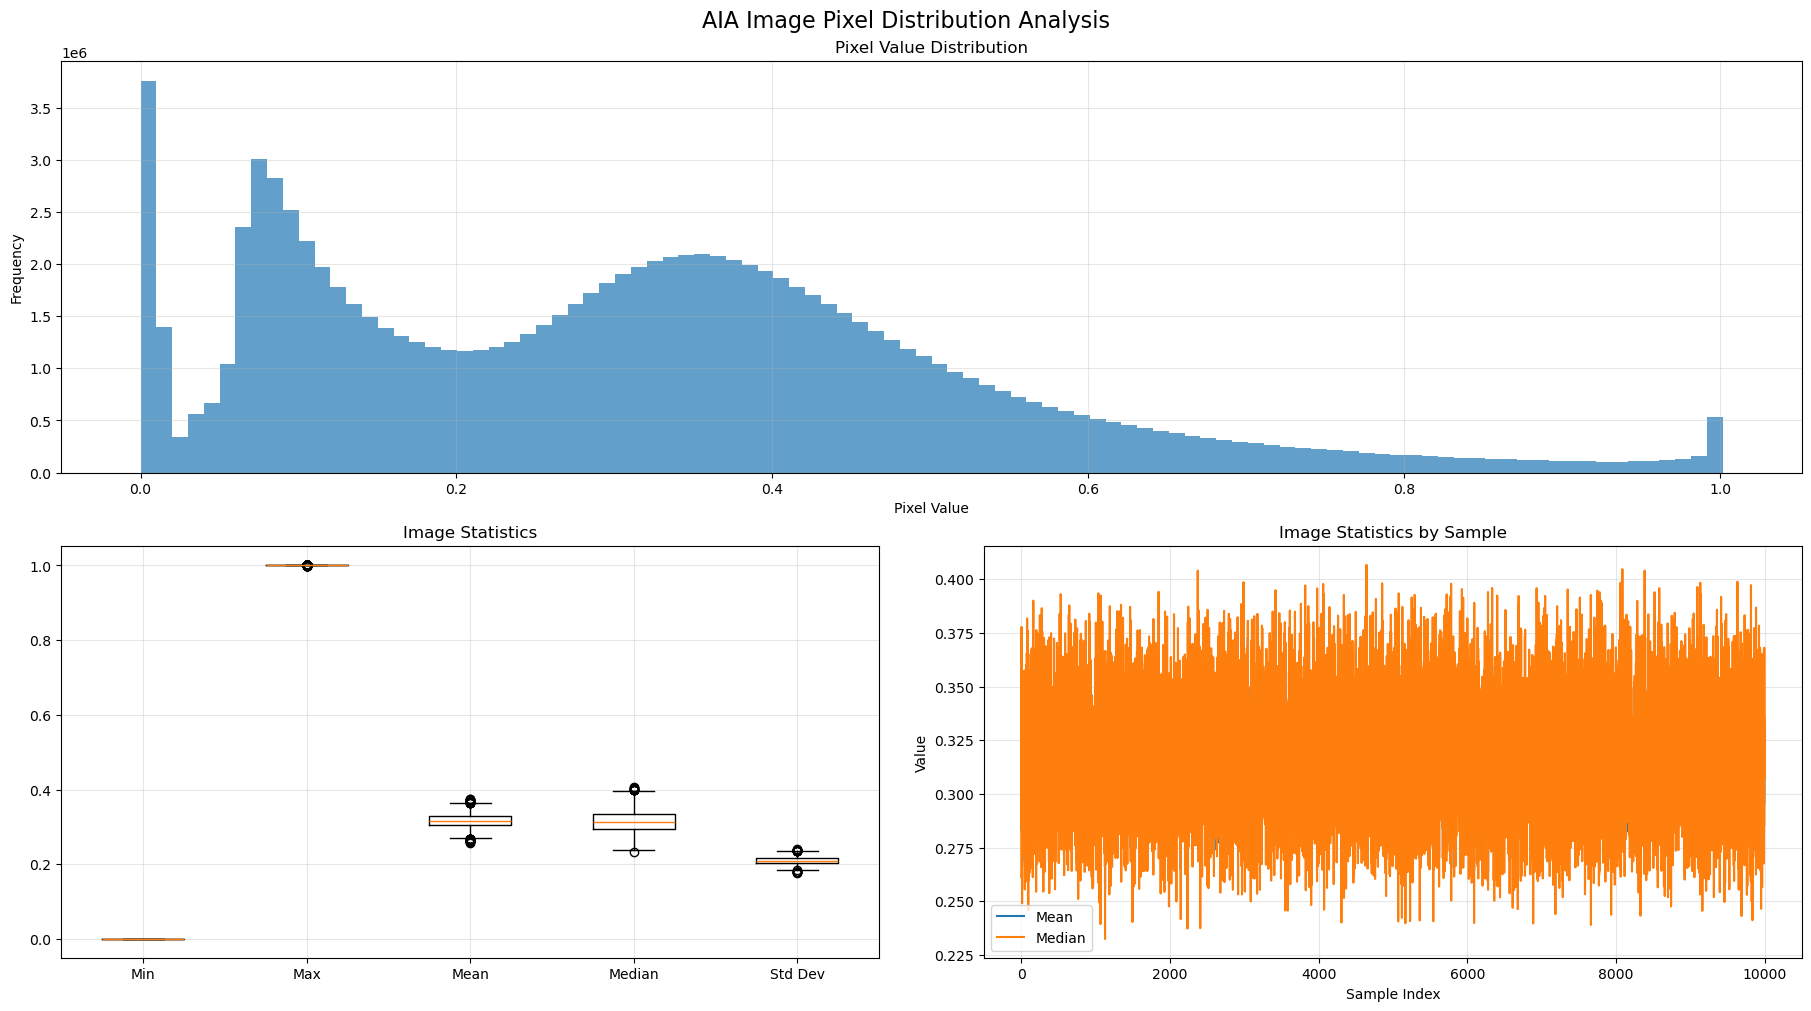

Overall statistics:
Min value: 0.0
Max value: 1.0014300346374512
Mean value: 0.3166782259941101
Median value: 0.31320473551750183
Std Dev: 0.20953388512134552
5th percentile: 0.016068613156676292
95th percentile: 0.7067379355430603
1 percentile: 0.004430410452187061
99th percentile: 0.9564275741577148


In [7]:
# Calculate pixel value distribution after clipping
pixel_values = []
min_vals = []
max_vals = []
mean_vals = []
median_vals = []
std_vals = []

# Sample a subset of files for faster processing if there are many files
sample_size = min(10000, len(aia_files_1))
sampled_files = np.random.choice(aia_files_1, size=sample_size, replace=False)

for aia_file in tqdm(sampled_files, desc="Calculating pixel distribution"):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path) as hdul:
            data = hdul[1].data
            
            # Collect statistics
            min_vals.append(np.min(data))
            max_vals.append(np.max(data))
            mean_vals.append(np.mean(data))
            median_vals.append(np.median(data))
            std_vals.append(np.std(data))
            
            # Sample pixels for histogram (to avoid memory issues)
            flat_data = data.flatten()
            sampled_pixels = flat_data[np.random.randint(0, len(flat_data), size=10000)]
            pixel_values.extend(sampled_pixels)
    except Exception as e:
        print(f"Error processing {aia_file}: {e}")

# Create visualization
fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Histogram of all pixel values
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(pixel_values, bins=100, alpha=0.7)
ax1.set_title('Pixel Value Distribution')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Statistics
ax2 = fig.add_subplot(gs[1, 0])
ax2.boxplot([min_vals, max_vals, mean_vals, median_vals, std_vals])
ax2.set_xticklabels(['Min', 'Max', 'Mean', 'Median', 'Std Dev'])
ax2.set_title('Image Statistics')
ax2.grid(True, alpha=0.3)

# Image statistics over time
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(mean_vals, label='Mean')
ax3.plot(median_vals, label='Median')
ax3.set_title('Image Statistics by Sample')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('AIA Image Pixel Distribution Analysis', fontsize=16)
plt.show()

# Print summary statistics
print(f"Overall statistics:")
print(f"Min value: {np.min(min_vals)}")
print(f"Max value: {np.max(max_vals)}")
print(f"Mean value: {np.mean(mean_vals)}")
print(f"Median value: {np.median(median_vals)}")
print(f"Std Dev: {np.mean(std_vals)}")

# Calculate 5th and 95th percentiles
p5 = np.percentile(pixel_values, 5)
p95 = np.percentile(pixel_values, 95)

# Add to the statistics output
print(f"5th percentile: {p5}")
print(f"95th percentile: {p95}")

# Calculate 5th and 95th percentiles
p1 = np.percentile(pixel_values, 1)
p99 = np.percentile(pixel_values, 99)

# Add to the statistics output
print(f"1 percentile: {p1}")
print(f"99th percentile: {p99}")

#### Clip values between 1 and 99 percentile, apply sqrt scaling and min-max scaling

In [4]:
def clip_scale_values(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            
            # Calculate percentiles for this specific image
            p1 = max(np.percentile(data, 1), 0)  # Ensure p1 is at least 0
            p99 = np.percentile(data, 99)
            
            # Clip the values between p1 and p99
            data_clipped = np.clip(data, p1, p99)
            
            # square root transform
            data_scaled = np.sqrt(data_clipped)
            
            # Min-max scaling to range [0, 1]
            min_val = np.min(data_scaled)
            max_val = np.max(data_scaled)
            data_min_max_scaled = (data_scaled - min_val) / (max_val - min_val)
            
            # Save the clipped image
            hdul[1].data = data_min_max_scaled
            
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(clip_scale_values, aia_files), total=len(aia_files), desc="Clipping Values"))

Clipping Values:   0%|          | 0/121972 [00:00<?, ?it/s]

#### Make 2 copies

In [5]:
def copy_files_twice(aia_file):
    try:
        # Copy the file to a new directory
        shutil.copy(aia_file_path, "D:\\aia_synoptic_copy_1")
        shutil.copy(aia_file_path, "D:\\aia_synoptic_copy_2")
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file}, Error: {e}"
    return None

with ThreadPoolExecutor(max_workers=30) as executor:
    list(tqdm(executor.map(copy_files_twice, aia_files), total=len(aia_files), desc="Copying files"))



Copying files:   0%|          | 0/121972 [00:00<?, ?it/s]

#### Get files from new directory

In [4]:
aia_files_1 = [os.path.join("D:\\aia_synoptic_copy_1", f) for f in os.listdir("D:\\aia_synoptic_copy_1") if f.endswith('.fits')]
aia_files_2 = [os.path.join("D:\\aia_synoptic_copy_2", f) for f in os.listdir("D:\\aia_synoptic_copy_2") if f.endswith('.fits')]
print(f"Files in copy 1: {len(aia_files_1)}")
print(f"Files in copy 2: {len(aia_files_2)}")

Files in copy 1: 121972
Files in copy 2: 121972


#### Downscale to 224 x 224

In [ ]:
    
def downscale_file(aia_file1, aia_file2):
    # Open first file and downscale with anti-aliasing
    try:
        with fits.open(aia_file1, mode="update", memmap=True) as hdul1:
            data1 = hdul1[1].data
            image_pil = Image.fromarray(data1)
            resized_data_1 = image_pil.resize((224, 224), Image.BILINEAR)
            resized_image_np1 = np.array(resized_data_1)
            # Save the downscaled anti-aliased image
            hdul1[1].data = resized_image_np1
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file1}, Error: {e}"

    # Open second file and downscale without anti-aliasing
    try:
        with fits.open(aia_file2, mode="update", memmap=True) as hdul2:
            data2 = hdul2[1].data
            resized_data_2 = cv2.resize(data2, (224, 224), interpolation=cv2.INTER_LINEAR)
            # Save the downscaled non-anti-aliased image
            hdul2[1].data = resized_data_2
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file2}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=30) as executor:
    list(tqdm(executor.map(downscale_file, aia_files_1, aia_files_2), total=len(aia_files_1), desc="Downscaling to 224x224"))

Downscaling to 224x224:   0%|          | 0/121972 [00:00<?, ?it/s]

In [6]:

def normalize_file(aia_file1, aia_file2):
    # Open first file
    try:
        with fits.open(aia_file1, mode="update", memmap=True) as hdul1:
            data1 = hdul1[1].data
            # Min-max scaling to range [0, 1]
            min_val_1 = np.min(data1)
            max_val_1 = np.max(data1)
            data_min_max_scaled_1 = (data1 - min_val_1) / (max_val_1 - min_val_1)
            # Save the downscaled anti-aliased image
            hdul1[1].data = data_min_max_scaled_1
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file1}, Error: {e}"

    # Open second file
    try:
        with fits.open(aia_file2, mode="update", memmap=True) as hdul2:
            data2 = hdul2[1].data
            # Min-max scaling to range [0, 1]
            min_val_2 = np.min(data2)
            max_val_2 = np.max(data2)
            data_min_max_scaled_2 = (data2 - min_val_2) / (max_val_2 - min_val_2)
            hdul2[1].data = data_min_max_scaled_2
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file2}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=30) as executor:
    list(tqdm(executor.map(normalize_file, aia_files_1, aia_files_2), total=len(aia_files_1), desc="Normalizing to [0, 1]"))

Normalizing to [0, 1]:   0%|          | 0/121972 [00:00<?, ?it/s]